In [1]:
### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()
# Country Data COUNTRY table
COUNTRY_df = pd.read_sql_query("select * from COUNTRY;", conn)
# League data from LEAGUE
LEAGUE_df = pd.read_sql_query("select * from LEAGUE;", conn)
#
Team_df = pd.read_sql_query("select * from TEAM;", conn)
# Match data from Matches - just pulling 1 year for now -2015/2016 might be latest year
# You can remove restriction if you want
#MATCH_df = pd.read_sql_query("select * from MATCH where SEASON = '2015/2016';", conn)
# Match data from Matches - just pulling 1 and relevant data for now - we can remove restriction later if we want
MATCH_df = pd.read_sql_query("SELECT DATE, LEAGUE_ID, HOME_TEAM_API_ID, AWAY_TEAM_API_ID, HOME_TEAM_GOAL, AWAY_TEAM_GOAL FROM MATCH WHERE SEASON = '2015/2016' ;",
conn)

### We calculate the "differential" for both the home team and away team

# FIND MOST DOMINATE BY 

MATCH_df["HOME_DIFF"] = MATCH_df["home_team_goal"]- MATCH_df["away_team_goal"]
MATCH_df["AWAY_DIFF"] = MATCH_df["away_team_goal"]- MATCH_df["home_team_goal"]

MATCH_home_df=MATCH_df.loc[:,["date","home_team_api_id", "HOME_DIFF","league_id","away_team_api_id"]]
MATCH_away_df=MATCH_df.loc[:,["date","away_team_api_id", "AWAY_DIFF","league_id","home_team_api_id"]]

MATCH_away_df.head()
MATCH_home_df.head()



MATCH_away_df.head()


# MATCH_away_df['W'] = '0' 
# MATCH_away_df['L'] = '0' 
# MATCH_away_df['T'] = '0' 
# MATCH_home_df['W'] = '0' 
# MATCH_home_df['L'] = '0' 
# MATCH_home_df['T'] = '0' 


# MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF >0, 'W'] = '1' 
# MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF <0, 'L'] = '1' 
# MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF ==0, 'T'] = '1' 

# MATCH_home_df.loc[MATCH_home_df.HOME_DIFF >0, 'W'] = '1' 
# MATCH_home_df.loc[MATCH_home_df.HOME_DIFF <0, 'L'] = '1' 
# MATCH_home_df.loc[MATCH_home_df.HOME_DIFF ==0, 'T'] = '1' 

# MATCH_away_df.head(5)

MATCH_away_df['W'] = 0 
MATCH_away_df['L'] = 0 
MATCH_away_df['T'] = 0 
MATCH_home_df['W'] = 0 
MATCH_home_df['L'] = 0 
MATCH_home_df['T'] = 0 


MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF >0, 'W'] = 1 
MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF <0, 'L'] = 1 
MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF ==0, 'T'] = 1 

MATCH_home_df.loc[MATCH_home_df.HOME_DIFF >0, 'W'] = 1 
MATCH_home_df.loc[MATCH_home_df.HOME_DIFF <0, 'L'] = 1 
MATCH_home_df.loc[MATCH_home_df.HOME_DIFF ==0, 'T'] = 1 

MATCH_away_df.head(5)



### We combine the home team data with the away team data to create 1 liast of games, with the differential

MATCH_home_df = MATCH_home_df.rename(columns={"home_team_api_id": "team_api_id","HOME_DIFF":"DIFF","away_team_api_id": "opponent" })
MATCH_away_df = MATCH_away_df.rename(columns={"away_team_api_id": "team_api_id","AWAY_DIFF":"DIFF","home_team_api_id": "opponent" })

MATCH_away_df.sort_values(by=["team_api_id","date"]).head(5)



,date,team_api_id,DIFF,league_id,opponent,W,L,T
2173,2015-08-03 00:00:00,1601,1,15722,8245,1,0,0
2197,2015-08-16 00:00:00,1601,-1,15722,1957,0,1,0
2213,2015-08-29 00:00:00,1601,-2,15722,8021,0,1,0
2005,2015-09-26 00:00:00,1601,-1,15722,2186,0,1,0
2023,2015-10-17 00:00:00,1601,0,15722,2182,0,0,1


In [2]:




frames = [MATCH_home_df, MATCH_away_df]
all_games_unsorted = pd.concat(frames)
all_games = all_games_unsorted.sort_values(by=["team_api_id","date"])
all_games.reset_index(inplace=True)
all_games.head() 

### We want to figure out the what the differential was for the next game as well.  
### We will make a copy of the table, and add "ng_" as a suffix to the columns for "next game"

next_game_unsorted = all_games.copy()
next_game_unsorted = next_game_unsorted.rename(columns={"DIFF": "ng_DIFF",
                                      "team_api_id": "ng_team_api_id2",
                                      "league_id":   "ng_league_id",
                                      "date":   "ng_date",
                                      "W": "ng_W",
                                      "L": "ng_L",
                                      "T": "ng_T" })

next_game = next_game_unsorted.sort_values(by=["ng_team_api_id2","ng_date"])
next_game.head()

### We will merge the original data to the copy, but shift the copy data by one row, so it will line up with the next game

#df_complete = pd.merge(all_games, next_game.shift(-1).fillna(0).astype(int), left_index=True, right_index=True)
df_complete = pd.merge(all_games, next_game.shift(-1).fillna(0), left_index=True, right_index=True)
df_complete.head(5)

,index_x,date,team_api_id,DIFF,league_id,opponent_x,W,L,T,index_y,ng_date,ng_team_api_id2,ng_DIFF,ng_league_id,opponent_y,ng_W,ng_L,ng_T
0,1995,2015-07-18 00:00:00,1601,-2,15722,8019,0,1,0,2084.0,2015-07-24 00:00:00,1601.0,2.0,15722.0,8028.0,1.0,0.0,0.0
1,2084,2015-07-24 00:00:00,1601,2,15722,8028,1,0,0,2173.0,2015-08-03 00:00:00,1601.0,1.0,15722.0,8245.0,1.0,0.0,0.0
2,2173,2015-08-03 00:00:00,1601,1,15722,8245,1,0,0,2188.0,2015-08-10 00:00:00,1601.0,0.0,15722.0,8033.0,0.0,0.0,1.0
3,2188,2015-08-10 00:00:00,1601,0,15722,8033,0,0,1,2197.0,2015-08-16 00:00:00,1601.0,-1.0,15722.0,1957.0,0.0,1.0,0.0
4,2197,2015-08-16 00:00:00,1601,-1,15722,1957,0,1,0,2204.0,2015-08-22 00:00:00,1601.0,3.0,15722.0,177361.0,1.0,0.0,0.0


In [3]:
### Oops!  For the last game of the season (where we don't have a next game), checking the next game would have returned the next team's first game.  We should just zero that out.      

#df.loc[df.First_name == 'Bill', 'name_match'] = 'Match' 
df_complete.sort_values(by=["team_api_id","date"]).head()
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2, "ng_DIFF"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2, "ng_league_id"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2, "opponent_y"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2, "ng_date"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2, "ng_W"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2, "ng_L"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2, "ng_T"] = 0



df_complete.head(2)

### Let's delete all the extra columns we created

df_complete.drop(['index_x','index_y','ng_date','ng_league_id'], axis=1, inplace=True)
df_complete.head()

# df_complete rules!  

### Now, lets find the most dominant team.  We will do that by grouping by the bext team


df_teams = df_complete.groupby(['league_id','team_api_id'], as_index=False).sum()


# df_teams = df_complete.groupby(['league_id','team_api_id']).sum()
df_teams.head(5)
#df_teams.drop(['opponent_x','ng_team_api_id2','opponent_y'], axis=1, inplace=True)


#df_teams.head(50)
# Groups to get season DIFF and ng_DIFF and all teams so 


### For each league, we will append the team that has the maximum Differential.  These are our dominant teams

leagues = df_teams.league_id.unique()
x = []
for l in leagues:
    df_test = df_teams[df_teams.league_id == l]
    x.append(df_test['team_api_id'].loc[df_test['DIFF'].idxmax()])
print(x)

#df_complete.opponent_x.unique()


dom_match = df_complete[df_complete.opponent_x.isin(x)]
dom_match.head()

#dom_match.opponent_y.value_counts()

df_teams.head()



df_DIFF = df_teams[["team_api_id","DIFF"]]
df_DIFF = df_DIFF.rename(columns={"DIFF": "total_DIFF"})
df_DIFF.head(5)

dom_match.head()

# Get the season DIFF for the 
merge_table_all = pd.merge(dom_match, df_DIFF,left_on="team_api_id", right_on="team_api_id")
 
merge_table_c = merge_table_all.rename(columns={"opponent_x": "dom_team",
                                          "team_api_id": "team",
                                      "opponent_y": "ng_opponent",
                                      "total_DIFF":   "team_season_DIFF"                                  
                                                                     })


merge_table_c.head()

merge_table_b = pd.merge(merge_table_c, df_DIFF,left_on="dom_team", right_on="team_api_id")
merge_table_b = merge_table_b.rename(columns={"total_DIFF": "dom_season_DIFF"})
merge_table_b.drop(['team_api_id'], axis=1, inplace=True)
merge_table_b.head(5)


merge_table = pd.merge(merge_table_b, df_DIFF,left_on="ng_opponent", right_on="team_api_id")
merge_table = merge_table.rename(columns={"total_DIFF": "ng_opp_season_DIFF"})
merge_table.head(5)


merge_table.drop(['team_api_id'], axis=1, inplace=True)

#merge_table.value_count("ng_opponent")
#merge_table.ng_opponent.value_counts()
merge_table = merge_table.rename(columns={"ng_team_api_id2": "shift_team",
                                         "league_id":   "league",
                                       "ng_opponent":   "ng_oppo",
                                       "team_season_DIFF": "team_szn_DIFF",
                                       "dom_season_DIFF":  "dom_szn_DIFF",
                                       "ng_opp_season_DIFF": "ng_oppo_szn_DIFF"  }) 




merge_table

# df_teams.head() has the 
df_teams_WLT = df_teams[["team_api_id","W","L","T"]].copy()
#df_teams_WLT["win_%"]=df_teams_WLT[['T']] + df_teams_WLT[['L']]
#+ df_teams_WLT.L + df_teams_WLT.L
#df_teams_WLT.head()
#df_teams_WLT[["win_percent"]]=df_teams_WLT["W"


df_teams_WLT['total_games'] = df_teams_WLT.apply(lambda x: x['W'] + x['L'] + x['T'], axis=1)
df_teams_WLT['win_rate'] = df_teams_WLT.apply(lambda x: x['W'] / x['total_games'], axis=1)

df_teams_WLT.head()
                                          

#merge_table.head()

### DATA TABLES

#df_teams_WLT 
#Has the total W/L/T and winning percentage of each team

#merge_table
#Has all the rows 





[8342, 8586, 9847, 9823, 9885, 8593, 8673, 9772, 9925, 8634, 9931]


,team_api_id,W,L,T,total_games,win_rate
0,1773,7,15,8,30,0.233333
1,8203,10,13,7,30,0.333333
2,8342,21,8,1,30,0.700000
3,8475,9,15,6,30,0.300000
4,8571,10,11,9,30,0.333333


In [4]:
merge_table.head()

,date,team,DIFF,league,dom_team,W,L,T,shift_team,ng_DIFF,ng_oppo,ng_W,ng_L,ng_T,team_szn_DIFF,dom_szn_DIFF,ng_oppo_szn_DIFF
0,2015-09-20 00:00:00,1601,-3,15722,8673,0,1,0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15
1,2016-02-28 00:00:00,1601,-2,15722,8673,0,1,0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15
2,2015-09-11 00:00:00,8021,0,15722,8673,0,0,1,8021.0,2.0,2186.0,1.0,0.0,0.0,4,30,15
3,2016-02-21 00:00:00,8021,-1,15722,8673,0,1,0,8021.0,1.0,2186.0,1.0,0.0,0.0,4,30,15
4,2015-07-26 00:00:00,8033,-5,15722,8673,0,1,0,8033.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15


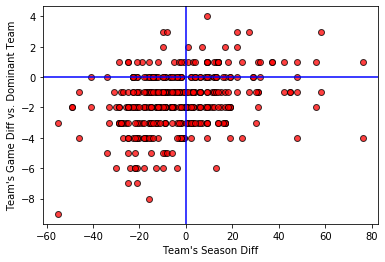

In [5]:


plt.xlabel("Team's Season Diff")
plt.ylabel("Team's Game Diff vs. Dominant Team")
plt.axhline(0, color='b')
plt.axvline(0, color='b')
plt.scatter(merge_table["team_szn_DIFF"], merge_table["DIFF"], marker="o", facecolors="red", edgecolors="black",
            alpha=0.75)

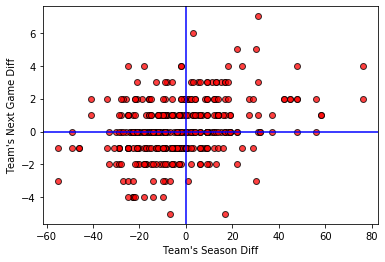

In [6]:
#Note: 
#shift_team is the team we merged on when we shifted.  If it's not the same as team it is the last game of the season

# scatter_x = merge_table["team_season_DIFF"]
# scatter_y = merge_table["ng_DIFF"]
# group = merge_table["league_id"]
# cdict = {0:"red",1:"orange",2:"blue",3:"green",4:"yellow",5:"black",6:"cyan",7:"magenta",8:"brown",9:"lime",10:"pink"}
# fig, ax = plt.subplots()
# for g in np.unique(group):
#     ix = np.where(group == g)
#     ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
# ax.legend()
# plt.show()

plt.xlabel("Team's Season Diff")
plt.ylabel("Team's Next Game Diff")
plt.axhline(0, color='b')
plt.axvline(0, color='b')
plt.scatter(merge_table["team_szn_DIFF"], merge_table["ng_DIFF"], marker="o", facecolors="red", edgecolors="black",
            alpha=0.75)








In [7]:
merge_table["dom_team"].unique()
#dom_team has 11 elements and dom_DIFF only has 9 elements

#dom_DIFF = merge_table["dom_season_DIFF"].unique()
#plt.bar(dom_team, dom_DIFF, color='r', alpha=0.5, align="center")


array([8673, 8342, 9772, 9847, 8593, 8634, 9931, 9885, 9925, 9823, 8586],
      dtype=int64)

In [8]:
#df_teams_wlt.head()

df_teams_WLT.head()

,team_api_id,W,L,T,total_games,win_rate
0,1773,7,15,8,30,0.233333
1,8203,10,13,7,30,0.333333
2,8342,21,8,1,30,0.700000
3,8475,9,15,6,30,0.300000
4,8571,10,11,9,30,0.333333


In [9]:
bins = [0, 0.4, 0.45, 0.5, 0.55, 0.9]
group_names = ["F", "D", "C", "B", "A"]
df_teams_WLT["Team Win Pctg"] = pd.cut(df_teams_WLT["win_rate"], bins, labels=group_names)
df_teams_WLT.head()
#plt.bar(df_teams_WLT["Team Win Pctg"], merge_table["ng_WIN"].sum(), color='r', alpha=0.5, align="center")


,team_api_id,W,L,T,total_games,win_rate,Team Win Pctg
0,1773,7,15,8,30,0.233333,F
1,8203,10,13,7,30,0.333333,F
2,8342,21,8,1,30,0.700000,A
3,8475,9,15,6,30,0.300000,F
4,8571,10,11,9,30,0.333333,F


In [10]:
df_teams_WLT.head()

,team_api_id,W,L,T,total_games,win_rate,Team Win Pctg
0,1773,7,15,8,30,0.233333,F
1,8203,10,13,7,30,0.333333,F
2,8342,21,8,1,30,0.700000,A
3,8475,9,15,6,30,0.300000,F
4,8571,10,11,9,30,0.333333,F


In [11]:
merge_table.head()


,date,team,DIFF,league,dom_team,W,L,T,shift_team,ng_DIFF,ng_oppo,ng_W,ng_L,ng_T,team_szn_DIFF,dom_szn_DIFF,ng_oppo_szn_DIFF
0,2015-09-20 00:00:00,1601,-3,15722,8673,0,1,0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15
1,2016-02-28 00:00:00,1601,-2,15722,8673,0,1,0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15
2,2015-09-11 00:00:00,8021,0,15722,8673,0,0,1,8021.0,2.0,2186.0,1.0,0.0,0.0,4,30,15
3,2016-02-21 00:00:00,8021,-1,15722,8673,0,1,0,8021.0,1.0,2186.0,1.0,0.0,0.0,4,30,15
4,2015-07-26 00:00:00,8033,-5,15722,8673,0,1,0,8033.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15


In [12]:
# merge_group = merge_table.groupby(['league','dom_team', 'dom_szn_DIFF'], as_index=False).mean()
# merge_group_clean = merge_group.drop(['team','shift_team','ng_oppo','team_szn_DIFF','ng_oppo_szn_DIFF'], axis=1)
# merge_group.clean(12)


In [13]:
df_teams_WLT['loss_rate'] = df_teams_WLT.apply(lambda x: x['L'] / x['total_games'], axis=1)
df_teams_WLT['tie_rate'] = df_teams_WLT.apply(lambda x: x['T'] / x['total_games'], axis=1)
df_teams_WLT.head()


,team_api_id,W,L,T,total_games,win_rate,Team Win Pctg,loss_rate,tie_rate
0,1773,7,15,8,30,0.233333,F,0.500000,0.266667
1,8203,10,13,7,30,0.333333,F,0.433333,0.233333
2,8342,21,8,1,30,0.700000,A,0.266667,0.033333
3,8475,9,15,6,30,0.300000,F,0.500000,0.200000
4,8571,10,11,9,30,0.333333,F,0.366667,0.300000


In [14]:
df_teams_WLT.head(50)

#pivot_df = df_teams_WLT.pivot(index="Team Win Pctg", columns = ])

,team_api_id,W,L,T,total_games,win_rate,Team Win Pctg,loss_rate,tie_rate
0,1773,7,15,8,30,0.233333,F,0.500000,0.266667
1,8203,10,13,7,30,0.333333,F,0.433333,0.233333
2,8342,21,8,1,30,0.700000,A,0.266667,0.033333
3,8475,9,15,6,30,0.300000,F,0.500000,0.200000
4,8571,10,11,9,30,0.333333,F,0.366667,0.300000
5,8573,14,9,7,30,0.466667,C,0.300000,0.233333
6,8635,15,5,10,30,0.500000,C,0.166667,0.333333
7,9985,12,13,5,30,0.400000,F,0.433333,0.166667
8,9986,10,11,9,30,0.333333,F,0.366667,0.300000
9,9987,14,10,6,30,0.466667,C,0.333333,0.200000


No handles with labels found to put in legend.


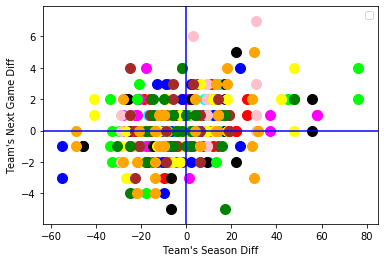

In [15]:
# SHALESH CUT AND PASTED CODE

scatter_x = merge_table["team_szn_DIFF"]
scatter_y = merge_table["ng_DIFF"]
group = merge_table["league"]
cdict = {1:"red",1729:"orange",4769:"blue",7809:"green",10257:"yellow",13274:"black",15722:"cyan",17642:"magenta",19694:"brown",21518:"lime",24558:"pink"}
fig, ax = plt.subplots()
for index, row in merge_table.iterrows():
    g=group[index]
    ax.scatter(scatter_x[index], scatter_y[index], c = cdict[g], s = 100)
ax.legend()

plt.xlabel("Team's Season Diff")
plt.ylabel("Team's Next Game Diff")
plt.axhline(0, color='b')
plt.axvline(0, color='b')
# plt.scatter(merge_table["team_szn_DIFF"], merge_table["ng_DIFF"], marker="o", facecolors="red", edgecolors="black",
#             alpha=0.75)

plt.show()


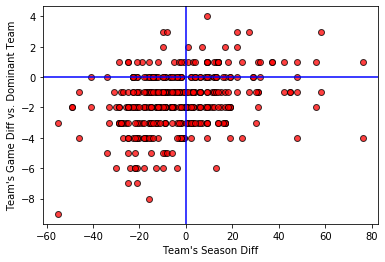

In [16]:


plt.xlabel("Team's Season Diff")
plt.ylabel("Team's Game Diff vs. Dominant Team")
plt.axhline(0, color='b')
plt.axvline(0, color='b')
plt.scatter(merge_table["team_szn_DIFF"], merge_table["DIFF"], marker="o", facecolors="red", edgecolors="black",
            alpha=0.75)




In [17]:
dom_team = merge_table["dom_team"].unique()
dom_DIFF = merge_table["dom_szn_DIFF"].unique()
for i in range(len(dom_team)):
    x.append(dom_DIFF)
#plt.bar(dom_team, dom_DIFF, color='r', alpha=0.5, align="center")




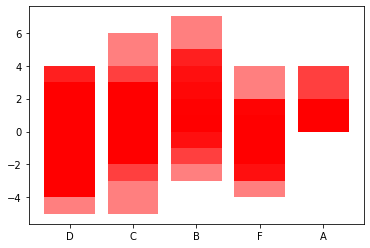

In [18]:
bins = [-60, -25, 0, 20, 35, 80]
group_names = ["F", "D", "C", "B", "A"]
merge_table["Team Quality"] = pd.cut(merge_table["team_szn_DIFF"], bins, labels=group_names)
plt.bar(merge_table["Team Quality"], merge_table["ng_DIFF"], color='r', alpha=0.5, align="center")
plt.show()






In [19]:
merge_table.head()

,date,team,DIFF,league,dom_team,W,L,T,shift_team,ng_DIFF,ng_oppo,ng_W,ng_L,ng_T,team_szn_DIFF,dom_szn_DIFF,ng_oppo_szn_DIFF,Team Quality
0,2015-09-20 00:00:00,1601,-3,15722,8673,0,1,0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15,D
1,2016-02-28 00:00:00,1601,-2,15722,8673,0,1,0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15,D
2,2015-09-11 00:00:00,8021,0,15722,8673,0,0,1,8021.0,2.0,2186.0,1.0,0.0,0.0,4,30,15,C
3,2016-02-21 00:00:00,8021,-1,15722,8673,0,1,0,8021.0,1.0,2186.0,1.0,0.0,0.0,4,30,15,C
4,2015-07-26 00:00:00,8033,-5,15722,8673,0,1,0,8033.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15,D


In [20]:

df_teams_WLT["points"] = df_teams_WLT["W"]*3 + df_teams_WLT["T"]
bins = [0, 36, 42, 49, 60.0,999]
group_names = ["F", "D", "C", "B", "A"]
df_teams_WLT["Team Win Pctg"] = pd.cut(df_teams_WLT["points"], bins, labels=group_names)
df_teams_WLT.head(5)
#plt.bar(df_teams_WLT["Team Win Pctg"], merge_table["ng_WIN"].sum(), color='r', alpha=0.5, align="center")
#df_teams_WLT["points"] = (df_teams_WLT.W*3 + df_teams_WLT.T)
#+ df_teams_WLT["T"]
#df_teams_WLT["points"] = df_teams_WLT["points"] + df_teams_WLT["tie_points"]

df_teams_WLT.head() 

,team_api_id,W,L,T,total_games,win_rate,Team Win Pctg,loss_rate,tie_rate,points
0,1773,7,15,8,30,0.233333,F,0.500000,0.266667,29
1,8203,10,13,7,30,0.333333,D,0.433333,0.233333,37
2,8342,21,8,1,30,0.700000,A,0.266667,0.033333,64
3,8475,9,15,6,30,0.300000,F,0.500000,0.200000,33
4,8571,10,11,9,30,0.333333,D,0.366667,0.300000,39


In [21]:
#df_teams_WLT.head()

#60     / 49   /42      / 36
# 37.6 / 75.2 / 112.8 / 150

#df_teams[df_teams_WLT.points > 40].count()#  122
#df_teams[df_teams_WLT.points > 59].count() #36

#df_teams[df_teams_WLT.points > 60].count() #36 
#df_teams[df_teams_WLT.points > 49].count() #73
#df_teams[df_teams_WLT.points > 42].count() #113
#df_teams[df_teams_WLT.points > 36].count() #### 150
#94



#df_teams[df_teams_WLT.points > 70].count() #94

#df_teams[df_teams_WLT.points > 50].count()  62


#df_teams[df_teams_WLT.loss_rate > .56].count()  #10 for 05%
# df_teams[df_teams_WLT.loss_rate > .48].count()  #34

#------# df_teams[df_teams_WLT.loss_rate > .48].count()  #34
#------#df_teams[df_teams_WLT.loss_rate > .42].count()   
#------df_teams[df_teams_WLT.loss_rate > .36].count()  #141 for 75%  113
# ---df_teams[df_teams_WLT.loss_rate > .28].count()  #141 for 75%  141



In [22]:
#merge_table # 377
#merge_table_bins = pd.merge(merge_table, df_teams_WLT,left_on="team_api_id", right_on="team_api_id")
#merge_table_bins.head()
#df_teams_WLT=df_teams_WLT.sort_values(by=["team_api_id"])
# 188
#all_games = all_games_unsorted.sort_values(by=["team_api_id","date"])
#df_teams_WLT # 188 rows

merge_table_group = merge_table.groupby(['league','team'], as_index=False).sum()

merge_table_group['total_ng'] = merge_table_group.apply(lambda x: x['W'] + x['L'] + x['T'], axis=1)
merge_table_group['win_rate_ng'] = merge_table_group.apply(lambda x: x['W'] / x['total_ng'], axis=1)
merge_table_group['loss_rate_ng'] = merge_table_group.apply(lambda x: x['L'] / x['total_ng'], axis=1)
merge_table_group['tie_rate_ng'] = merge_table_group.apply(lambda x: x['T'] / x['total_ng'], axis=1)
  
merge_table_group.head(5)


#merge_table_group # 177 -  11

#df_teams_WLT.head() #  team_api_id
#merge_table_group.head()  # team

merge_table_bins = pd.merge(merge_table_group, df_teams_WLT,left_on="team", right_on="team_api_id")
merge_table_bins.columns
# team / BIN / LEAGUE / 


#df_teams_WLT # 188

#df_teams_WLT.sort_values(by=["team_api_id"])


#unique_df_teams  = df_teams.team_api_id.unique()
#unique_df_teams


Index(['league', 'team', 'DIFF', 'dom_team', 'W_x', 'L_x', 'T_x', 'shift_team',
       'ng_DIFF', 'ng_oppo', 'ng_W', 'ng_L', 'ng_T', 'team_szn_DIFF',
       'dom_szn_DIFF', 'ng_oppo_szn_DIFF', 'total_ng', 'win_rate_ng',
       'loss_rate_ng', 'tie_rate_ng', 'team_api_id', 'W_y', 'L_y', 'T_y',
       'total_games', 'win_rate', 'Team Win Pctg', 'loss_rate', 'tie_rate',
       'points'],
      dtype='object')

In [23]:
#merge_table_group.head()
 
                       
                       
                       
                       

In [24]:
merge_table_bins.drop(['shift_team','ng_oppo','dom_team','league','team_api_id'], axis=1, inplace=True)


In [25]:
#merge_table_bins.drop(['shift_team','ng_oppo','dom_team','league','team_api_id'], axis=1, inplace=True)
merge_table_bins.head(6)


,team,DIFF,W_x,L_x,T_x,ng_DIFF,ng_W,ng_L,ng_T,team_szn_DIFF,...,tie_rate_ng,W_y,L_y,T_y,total_games,win_rate,Team Win Pctg,loss_rate,tie_rate,points
0,1773,-2,0,1,0,-2.0,0.0,1.0,0.0,-11,...,0.0,7,15,8,30,0.233333,F,0.500000,0.266667,29
1,8203,-6,0,2,0,3.0,2.0,0.0,0.0,-4,...,0.0,10,13,7,30,0.333333,D,0.433333,0.233333,37
2,8475,-5,0,2,0,-3.0,0.0,2.0,0.0,-34,...,0.0,9,15,6,30,0.300000,F,0.500000,0.200000,33
3,8571,-4,0,2,0,-1.0,0.0,1.0,1.0,-8,...,0.0,10,11,9,30,0.333333,D,0.366667,0.300000,39
4,8573,-3,0,2,0,3.0,1.0,0.0,1.0,22,...,0.0,14,9,7,30,0.466667,C,0.300000,0.233333,49
5,8635,5,2,0,0,0.0,0.0,0.0,2.0,44,...,0.0,15,5,10,30,0.500000,B,0.166667,0.333333,55


In [26]:
merge_table_group_bin = merge_table_bins.groupby(['Team Win Pctg'], as_index=False).sum()
merge_table_group_bin_mean = merge_table_bins.groupby(['Team Win Pctg'], as_index=False).mean()

merge_table_group_bin.head(12)
merge_table_group_bin.columns
#merge_table_group_bin.drop(['league','team','dom_team','shift_team','team_api_id'], axis=1, inplace=True)
merge_table_group_bin_mean.head()    

,Team Win Pctg,team,DIFF,W_x,L_x,T_x,ng_DIFF,ng_W,ng_L,ng_T,...,loss_rate_ng,tie_rate_ng,W_y,L_y,T_y,total_games,win_rate,loss_rate,tie_rate,points
0,F,24965.710526,-4.315789,0.105263,1.710526,0.315789,-0.657895,0.473684,0.868421,0.789474,...,0.817982,0.129386,7.263158,17.973684,8.710526,33.947368,0.216251,0.525781,0.257968,30.500000
1,D,14273.621622,-4.351351,0.135135,1.621622,0.243243,-0.648649,0.621622,0.945946,0.432432,...,0.817568,0.108108,9.756757,15.189189,9.918919,34.864865,0.282627,0.432331,0.285042,39.189189
2,C,8507.725000,-3.225000,0.125000,1.575000,0.375000,0.575000,0.800000,0.575000,0.700000,...,0.768750,0.168750,11.925000,13.850000,9.925000,35.700000,0.337515,0.384701,0.277784,45.700000
3,B,13264.777778,-2.722222,0.388889,1.444444,0.416667,0.583333,0.944444,0.611111,0.694444,...,0.620370,0.208333,14.888889,11.777778,9.166667,35.833333,0.418803,0.325629,0.255567,53.833333
4,A,9259.307692,-1.846154,0.653846,1.230769,0.346154,2.730769,1.384615,0.269231,0.576923,...,0.548077,0.153846,20.846154,7.730769,8.576923,37.153846,0.563878,0.206693,0.229430,71.115385


In [27]:
merge_table_group_bin_mean.drop(['team','DIFF','W_x','L_x','T_x','ng_DIFF','ng_W','ng_L'], axis=1, inplace=True)
merge_table_group_bin_mean.head()

,Team Win Pctg,ng_T,team_szn_DIFF,dom_szn_DIFF,ng_oppo_szn_DIFF,total_ng,win_rate_ng,loss_rate_ng,tie_rate_ng,W_y,L_y,T_y,total_games,win_rate,loss_rate,tie_rate,points
0,F,0.789474,-49.657895,112.605263,-16.078947,2.131579,0.052632,0.817982,0.129386,7.263158,17.973684,8.710526,33.947368,0.216251,0.525781,0.257968,30.500000
1,D,0.432432,-25.864865,107.837838,-14.486486,2.000000,0.074324,0.817568,0.108108,9.756757,15.189189,9.918919,34.864865,0.282627,0.432331,0.285042,39.189189
2,C,0.700000,-8.425000,123.925000,-9.800000,2.075000,0.062500,0.768750,0.168750,11.925000,13.850000,9.925000,35.700000,0.337515,0.384701,0.277784,45.700000
3,B,0.694444,9.305556,136.111111,-7.972222,2.250000,0.171296,0.620370,0.208333,14.888889,11.777778,9.166667,35.833333,0.418803,0.325629,0.255567,53.833333
4,A,0.576923,62.000000,132.538462,-27.269231,2.230769,0.298077,0.548077,0.153846,20.846154,7.730769,8.576923,37.153846,0.563878,0.206693,0.229430,71.115385


In [28]:
#merge_table_group_bin.drop(['ng_oppo','dom_szn_DIFF','ng_oppo_szn_DIFF','W_y','L_y','T_y','total_games'], axis=1, inplace=True)



In [29]:
# merge_table_group_bin.head()

# merge_table_group_bin.columns

merge_table_group_bin['total_ng'] = merge_table_group_bin.apply(lambda x: x['ng_W'] + x['ng_L'] + x['ng_T'], axis=1)
merge_table_group_bin['win_rate_ng'] = merge_table_group_bin.apply(lambda x: x['ng_W'] / x['total_ng'], axis=1)
merge_table_group_bin['loss_rate_ng'] = merge_table_group_bin.apply(lambda x: x['ng_L'] / x['total_ng'], axis=1)
merge_table_group_bin['tie_rate_ng'] = merge_table_group_bin.apply(lambda x: x['ng_T'] / x['total_ng'], axis=1)

merge_table_group_bin.head()


,Team Win Pctg,team,DIFF,W_x,L_x,T_x,ng_DIFF,ng_W,ng_L,ng_T,...,loss_rate_ng,tie_rate_ng,W_y,L_y,T_y,total_games,win_rate,loss_rate,tie_rate,points
0,F,948697,-164,4,65,12,-25.0,18.0,33.0,30.0,...,0.407407,0.370370,276,683,331,1290,8.217527,19.979687,9.802786,1159
1,D,528124,-161,5,60,9,-24.0,23.0,35.0,16.0,...,0.472973,0.216216,361,562,367,1290,10.457207,15.996233,10.546560,1450
2,C,340309,-129,5,63,15,23.0,32.0,23.0,28.0,...,0.277108,0.337349,477,554,397,1428,13.500619,15.388029,11.111352,1828
3,B,477532,-98,14,52,15,21.0,34.0,22.0,25.0,...,0.271605,0.308642,536,424,330,1290,15.076918,11.722652,9.200430,1938
4,A,240742,-48,17,32,9,71.0,36.0,7.0,15.0,...,0.120690,0.258621,542,201,223,966,14.660819,5.374011,5.965170,1849


In [30]:
merge_table_group_bin_mean.set_index('Team Win Pctg',inplace=True)
merge_table_group_bin.set_index('Team Win Pctg',inplace=True)

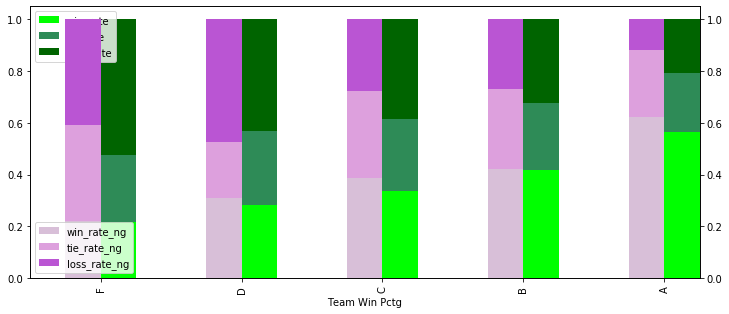

In [58]:
fig=plt.figure()

ax=fig.add_subplot(111)
ax2=ax.twinx()


width=.25

#ax = x.plot(kind='bar', legend=False)
patches, labels = ax.get_legend_handles_labels()
#ax.legend(patches, labels, loc='best')
ax.legend(patches, labels, loc='lower left')
ax2.legend(patches, labels, loc='lower left')


colors = ["lime","seagreen","darkgreen"]
colors2 = ["thistle", "plum","mediumorchid"]

merge_table_group_bin_mean.loc[:,['win_rate','tie_rate','loss_rate']].plot.bar(stacked=True,width=width,position=0, color=colors, ax=ax,align='center')
#figsize=(15,15),
#merge_table_group_bin.loc[:,['ng_W','ng_L','ng_T']].plot.bar(stacked=True,width=width, color=colors2, figsize=(15,10),position=1,ax=ax2)
merge_table_group_bin.loc[:,['win_rate_ng','tie_rate_ng','loss_rate_ng']].plot.bar(stacked=True,width=width,position=1, color=colors2, figsize=(12,5),ax=ax2,align='center')

ax.legend(patches, labels, loc='best')
ax2.legend(patches, labels, loc='right')
#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7),position=1,ax=ax)

#plt.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")

#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7))

#plt.show()
#merge_table_group_bin
ax.legend(fancybox=True, framealpha=0.5)
ax.legend(loc='upper left') 
ax2.legend(fancybox=True, framealpha=0.5)
ax2.legend(loc='lower left') 


#plt.legend(loc='best')


AttributeError: 'list' object has no attribute 'plot'

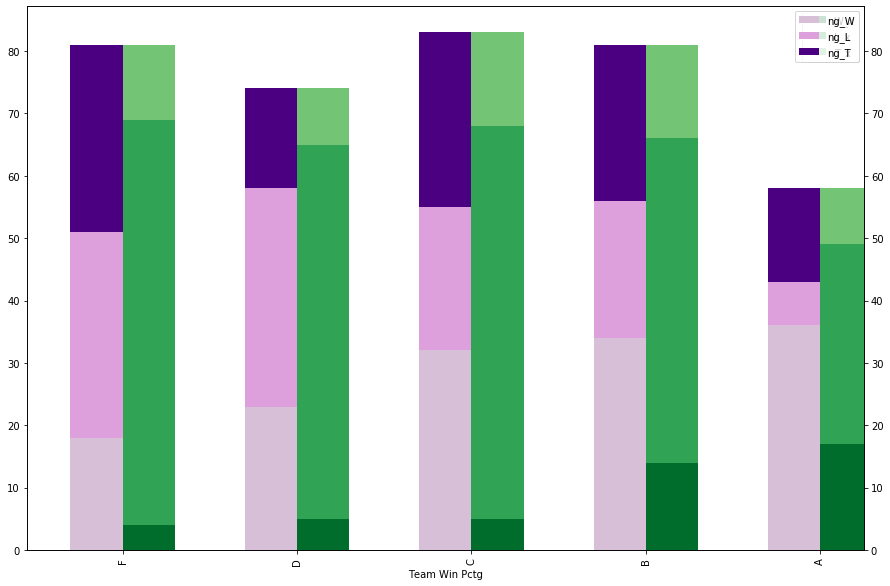

In [35]:
fig=plt.figure()

ax=fig.add_subplot(111)
ax2=ax.twinx()


width=.3

colors = ["#006D2C", "#31A354","#74C476"]
colors2 = ["thistle", "plum","indigo"]

merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True,width=width, color=colors, figsize=(15,10),position=0,ax=ax)
merge_table_group_bin.loc[:,['ng_W','ng_L','ng_T']].plot.bar(stacked=True,width=width, color=colors2, figsize=(15,10),position=1,ax=ax2)
[' ',' ',' '].plot.bar(stacked=True,width=width, color=colors2, figsize=(15,10),position=2,ax=ax2)


#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7),position=1,ax=ax)


#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7))

plt.show()
#merge_table_group_bin

In [33]:
#df_complete.drop(['index_x','index_y','ng_date','ng_league_id'], axis=1, inplace=True)
merge_table_group_bin.drop(['league','team','DIFF','dom_team','shift_team','team_api_id','win_rate','loss_rate','tie_rate'], axis=1, inplace=True)
merge_table_group_bin.head()


KeyError: "['league' 'dom_team' 'shift_team' 'team_api_id'] not found in axis"

In [ ]:
colors = ["#006D2C", "#31A354","#74C476"]
#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7))
#index = ["F","D","C","B","A"]
hello = merge_table_group_bin.loc[:,['ng_W','ng_L','ng_T']]#.plot.bar(stacked=True, color=colors, figsize=(10,7))
hello
#hello.plot.bar(stacked=True, color=colors, figsize=(10,7))

#dfx = pd.DataFrame(columns=['a', 'b', 'c', 'd'])
#dfx.plot()

#pd.DataFrame({'lab':['A', 'B', 'C','D','F']})
#merge_table_group_bin.head()

In [ ]:


data = [[2000, 2000, 2000, 2001, 2001, 2001, 2002, 2002, 2002],
        ['Jan', 'Feb', 'Mar', 'Jan', 'Feb', 'Mar', 'Jan', 'Feb', 'Mar'],
        [1, 2, 3, 4, 5, 6, 7, 8, 9]]

rows = zip(data[0], data[1], data[2])
headers = ['Year', 'Month', 'Value']
df = pd.DataFrame(rows, columns=headers)

df

In [ ]:
pivot_df = df.pivot(index='Year', columns='Month', values='Value')
pivot_df

In [ ]:
colors = ["#006D2C", "#31A354","#74C476"]
pivot_df.loc[:,['Jan','Feb', 'Mar']].plot.bar(stacked=True, color=colors, figsize=(10,7))

# Years = BINS  
# Months = W L T 



In [ ]:



#plt.bar(merge_table_bins["Team Win Pctg"], merge_table_bins["W_y"].unique(), color='r', alpha=0.5, align="center")

#pivot_df = df.pivot(index='Year', columns='Month', values='Value')


# This gives error . . . 
 



In [ ]:

                                                    Add
1773 7 15 8 30 0.233333 0.500000 0.266667 F 


8203 10 13 7 30 0.333333 0.433333 0.233333 F 


8342 21 8 1 30 0.700000 0.266667 0.033333 A 


8475 9 15 6 30 0.300000 0.500000 0.200000 F 


8571 10 11 9 30 0.333333 0.366667 0.300000 F 



# add to the bins, ng_

    next game   current game
    w  L   T   
A   ?  ?   ?
B   ?  ?   ?
C   ?  ?   ?
D   ?  ?   ?
F   ?  ?   ?
